# $Heston$ $Model$

In such model (originally created in 1993) the asset and the volatility are modelled by separate stochastic differential equations (SDEs).

d$S = \mu S_t$ d$t$ + $\sqrt{v(t)}S_t$ d$W^{(1)}_t$ ;

and determined by the following factors:

$S_t = $ $spot$ $price$
$W^{(1)}_t =$ $a$ $Wiener$ $process$
$v(t) =$ $variance$
$\mu =$ $(risk$ $neutral)$ $drift.$

Meanwhile, variance:

d$v(t)= \kappa[\theta- v(t)]$d$t + \sigma\sqrt{v(t)}$d$W^{(2)}_t$


where:

$\sigma = volatility$ $of$ $the$ $volatility$
$0 < \theta = long-term$ $variance$
$\theta < \kappa = rate$ $of$ $mean$ $reversion$
$W^{(2)}_t$ $is$ $a$ $Wiener$ $process$
$\rho$ $is$ $the$ $correlation$ $value$

The correlation between the two Wiener processes is given by:

d$W^{(1)}_t$ d$W^{(2)}_t = \rho$d$t$

One more requirement is $Feller$ $condition:$ $2\kappa\theta > \sigma^2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Monte Carlo Simulation

In [2]:
def heston_simulation(spot_0, v_0, r, rho, kappa, theta, sigma, time_y, steps, simulations):
    """

    :param spot_0: spot price
    :param v_0: initial variance
    :param r: risk-free rate
    :param rho: correlation value
    :param kappa: rate of mean reversion
    :param theta: long-term mean of variance
    :param sigma: volatility of volatility
    :param time_y: time in years
    :param steps: number of steps in simulation
    :param simulations: number of simulations
    :return: performs Heston simulations and return history of asset prices and variances
    """

    dt = time_y / steps

    mu = np.array([0, 0])
    cov = np.array([[1, rho], [rho, 1]])

    # storing history of asset prices and variances
    spot = np.full(shape=(steps + 1, simulations), fill_value=spot_0)
    variance = np.full(shape=(steps + 1, simulations), fill_value=v_0)

    z = np.random.multivariate_normal(mu, cov, (steps, simulations))

    for i in range(1, steps + 1):
        spot[i] = spot[i - 1] * np.exp(
            (r - 0.5 * variance[i - 1]) * dt + np.sqrt(variance[i - 1] * dt) * z[i - 1, :, 0])
        variance[i] = np.maximum(variance[i - 1] + kappa * (theta - variance[i - 1]) * dt +
                                 sigma * np.sqrt(variance[i - 1] * dt) * z[i - 1, :, 1], 0)

    return spot, variance

In [3]:
Spots, variances = heston_simulation(spot_0 = 139.59,
                                           v_0 = 0.25**2,
                                           r = 0.01,
                                           rho = 0.5,
                                           kappa = 3,
                                           theta = 0.2**2,
                                           sigma = 0.6,
                                           time_y = 1,
                                           steps = 252,
                                           simulations = 150
                                           )

### We want now to be able to observe simulations results, so let's implement functions for plotting graphs.

In [4]:
def plot_heston_simulation(spot_0, v_0, r, rho, kappa, theta, sigma,time_y, steps, simulations, fig_size=(12, 4)):
    spots, variances = heston_simulation(spot_0, v_0, r, rho, kappa, theta, sigma,time_y, steps, simulations)

    fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=fig_size)
    t = np.linspace(0, time_y, steps + 1)

    ax1.plot(t, spots)

    ax1.set_title('Heston Model Asset Prices')
    ax1.set_xlabel('Time')
    ax1.set_ylabel('Asset Prices')

    ax2.plot(t, variances)

    ax2.set_title('Heston Model Variance Process')
    ax2.set_xlabel('Time')
    ax2.set_ylabel('Variance')

    plt.show()


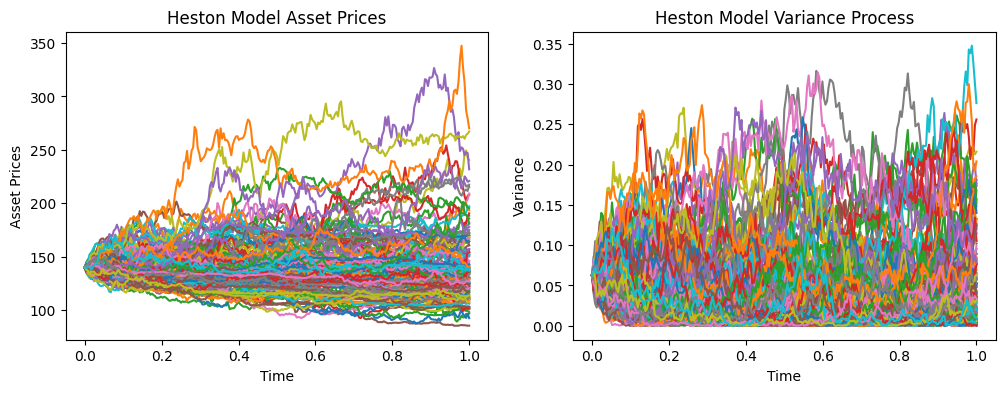

In [5]:
plot_heston_simulation(spot_0 = 139.59,
                        v_0 = 0.25**2,
                       r = 0.01,
                        rho = 0.5,
                        kappa = 3,
                        theta = 0.2**2,
                        sigma = 0.6,
                        time_y = 1,
                        steps = 252,
                        simulations = 150,
                        fig_size=(12, 4)
)

In [6]:
Spots.mean(), variances.mean()

(137.88027977364598, 0.04288228948616884)

# Price

The beauty of Heston's approach is its closed solution form, which we going to code.





In [7]:
complex_i = complex(0,1)

def heston_func(s, spot, strike, r, time, v, sigma, kappa, theta, rho):

    d1 = (rho * sigma * complex_i * s - kappa)**2
    d2 = (sigma**2) * (complex_i * s + s**2)
    d = np.sqrt(d1 + d2)

    g1 = kappa - rho * sigma * complex_i * s - d
    g2 = kappa - rho * sigma * complex_i * s + d
    g = g1 / g2

    exp11 = np.exp(np.log(spot) * complex_i * s) * np.exp(complex_i * s * r * time)
    exp12 = 1 - g * np.exp(-d * time)
    exp13 = 1 - g
    exp1 = exp11 * np.power(exp12 / exp13, -2 * theta * kappa / (sigma**2))

    exp21 = theta * kappa * time / (sigma**2)
    exp22 = v / (sigma**2)
    exp23 = (1 - np.exp(-d * time)) / (1 - g * np.exp(-d * time))
    exp2 = np.exp((exp21 * g1) + (exp22 * g1 * exp23))

    return exp1 * exp2

In [8]:
def heston_price(spot, strike, r, time, v, sigma, kappa, theta, rho):

    P, iterations, max_number = 0, 1000, 100
    ds = max_number / iterations
    part_1 = 0.5 * (spot - strike * np.exp(-r * time))

    for i in range(1, iterations):

        s1 = ds * (2 * complex_i + 1) * 0.5
        s2 = s1 - complex_i

        numerator_1 = heston_func(s2, spot, strike, r, time, v, sigma, kappa, theta, rho)
        numerator_2 = strike * heston_func(s1, spot, strike, r, time, v, sigma, kappa, theta, rho)

        denominator = np.exp(np.log(strike) * complex_i * s1) * complex_i * s1

        P += ds * (numerator_1 - numerator_2) / denominator

    part_2 = P / np.pi

    return np.real((part_1 + part_2))

We need to understand tha since it's not a close form solution sometimes it's not the most efficient way.

Hence might be performed another one and created a class for usability.

In [1]:
import numpy as np
import math as math
import cmath as cmath


class Heston(object):

    def __init__(self, S0, strike, time, r, kappa, theta, v0, lamda, sigma, rho):

        self.x0 = math.log(S0)
        self.ln_k = math.log(strike)
        self.r = r
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.lamda = lamda
        self.sigma = sigma
        self.rho = rho
        self.tau = time

        self.a = kappa * theta
        self.u = [0.5, -0.5]
        self.b = [kappa + lamda - rho * sigma, kappa + lamda]

    def reset_params(self, S0, strike, time, r, kappa, theta, v0, lamda, sigma, rho):
        # Function for resetting the constant parameters
        self.x0 = math.log(S0)
        self.ln_k = math.log(strike)
        self.r = r
        self.v0 = v0
        self.kappa = kappa
        self.theta = theta
        self.lamda = lamda
        self.sigma = sigma
        self.rho = rho
        self.tau = time

        self.a = kappa * theta
        self.u = [0.5, -0.5]
        self.b = [kappa + lamda - rho * sigma, kappa + lamda]

    def characteristic_func(self, phi):
        # Return the characteristic functions f1 and f2, each of which has a real and a complex part

        d = [0.0, 0.0]
        g = [0.0, 0.0]
        C = [0.0, 0.0]
        D = [0.0, 0.0]
        edt = [0.0, 0.0]
        gedt = [0.0, 0.0]
        f = [0.0, 0.0]

        for j in range(2):
            temp = self.b[j] - 1j * self.rho * self.sigma * phi

            d[j] = cmath.sqrt(temp ** 2 - self.sigma ** 2 * (2.0 * self.u[j] * phi * 1j - phi ** 2))

            g[j] = (temp + d[j]) / (temp - d[j])

            edt[j] = cmath.exp(d[j] * self.tau)
            gedt[j] = 1.0 - g[j] * edt[j]

            D[j] = (temp + d[j]) * (1.0 - edt[j]) / gedt[j] / self.sigma / self.sigma
            C[j] = self.r * phi * self.tau * 1j + self.a / self.sigma / self.sigma * (
                        (temp + d[j]) * self.tau - 2.0 * cmath.log(gedt[j] / (1.0 - g[j])))
            f[j] = cmath.exp(C[j] + D[j] * self.v0 + 1j * phi * self.x0)

        return f

    def f1(self, phi):
        # f1 only using a copy of the previous code with minimal change, i.e.,j=0 replaes loop

        d = [0.0, 0.0]
        g = [0.0, 0.0]
        C = [0.0, 0.0]
        D = [0.0, 0.0]
        edt = [0.0, 0.0]
        gedt = [0.0, 0.0]
        f = [0.0, 0.0]

        j = 0

        temp = self.b[j] - 1j * self.rho * self.sigma * phi

        d[j] = cmath.sqrt(temp ** 2 - self.sigma ** 2 * (2.0 * self.u[j] * phi * 1j - phi ** 2))
        g[j] = (temp + d[j]) / (temp - d[j])

        edt[j] = cmath.exp(d[j] * self.tau)
        gedt[j] = 1.0 - g[j] * edt[j]

        D[j] = (temp + d[j]) * (1.0 - edt[j]) / gedt[j] / self.sigma / self.sigma
        C[j] = self.r * phi * self.tau * 1j + self.a / self.sigma / self.sigma * (
                    (temp + d[j]) * self.tau - 2.0 * cmath.log(gedt[j] / (1.0 - g[j])))
        f[j] = cmath.exp(C[j] + D[j] * self.v0 + 1j * phi * self.x0)

        return f[0]

    def f2(self, phi):
        # f2 only using a copy of the previous code with minimal change, i.e.,now j=1 replaces loop

        d = [0.0, 0.0]
        g = [0.0, 0.0]
        C = [0.0, 0.0]
        D = [0.0, 0.0]
        edt = [0.0, 0.0]
        gedt = [0.0, 0.0]
        f = [0.0, 0.0]

        j = 1

        temp = self.b[j] - 1j * self.rho * self.sigma * phi

        d[j] = cmath.sqrt(temp ** 2 - self.sigma ** 2 * (2.0 * self.u[j] * phi * 1j - phi ** 2))
        g[j] = (temp + d[j]) / (temp - d[j])

        edt[j] = cmath.exp(d[j] * self.tau)
        gedt[j] = 1.0 - g[j] * edt[j]

        D[j] = (temp + d[j]) * (1.0 - edt[j]) / gedt[j] / self.sigma / self.sigma
        C[j] = self.r * phi * self.tau * 1j + self.a / self.sigma / self.sigma * (
                    (temp + d[j]) * self.tau - 2.0 * cmath.log(gedt[j] / (1.0 - g[j])))
        f[j] = cmath.exp(C[j] + D[j] * self.v0 + 1j * phi * self.x0)

        return f[1]

    def P1_integrand(self, phi):
        # Returns the integrand  that appears in the P1 formula
        temp = cmath.exp(-1j * phi * self.ln_k) * self.f1(phi) / 1j / phi
        return temp.real

    def P2_integrand(self, phi):
        # Returns the integrand  that appears in the P1 formula
        temp = cmath.exp(-1j * phi * self.ln_k) * self.f2(phi) / 1j / phi
        return temp.real

    def probability(self, a, b, n):
        # Compute the two probabilities: a and b are the integration limits, n is the number of intervals
        # usually the interval >0 to 100 captures the range that matters, so no need to go to b=infinity!

        pi_i = 1.0 / math.pi
        P1 = 0.5 + pi_i * trapzoid(self.P1_integrand, a, b, n)  # trapzd function is de
        P2 = 0.5 + pi_i * trapzoid(self.P2_integrand, a, b, n)
        P = [P1, P2]
        return P

    def price(self, a, b, n):
        Ps = self.probability(a, b, n)

        call_price = math.exp(self.x0) * Ps[0] - math.exp(self.ln_k - self.r * self.tau) * Ps[1]
        put_price = call_price - (math.exp(self.x0) - math.exp(self.ln_k - self.r * self.tau))

        output = {
            "call": call_price,
            "put": put_price
        }
        return output


def trapzoid(func, a, b, n):
    # Trapzoid method for numerical integration, one can also use a function from scipy.integrate library

    if (n < 1):
        return
    elif (n == 1):
        return 0.5 * (b - a) * (func(a) + func(b))
    else:

        temp = 0.0
        dx = (b - a) / n

        x = np.linspace(a, b, n + 1)
        y = [func(x[i]) for i in range(n + 1)]

        temp = 0.5 * dx * np.sum(y[1:] + y[:-1])
        return temp

Let's test it right away, with constant volatility (col of vol = 0), eliminating the trend, $v_0 = \theta = \sigma^{2}_{BSM}, computational result should not differ from BSM price.

In [3]:
heston_model = Heston(S0=100, strike=100, time=1.0, r=0.05, kappa=0.0, theta=0.01, v0=0.01, lamda=0.0, sigma=0.000001, rho=-0.7)

heston_call = heston_model.price(0.00001, 100, 10000)['call']
heston_put = heston_model.price(0.00001, 100, 10000)['put']


import OptionLib as opt
bsm_call = opt.BSM(r=.05, spot=100, strike=100, time=1.0, sigma=.1, type='call')
bsm_put = opt.BSM(r=.05, spot=100, strike=100, time=1.0, sigma=.1, type='put')


print("Heston Call Price:", "{:.5f}".format(heston_call))
print("BSM Call Price:   ", "{:.5f}".format(bsm_call))

print("Heston Put Price: ", "{:.5f}".format(heston_put))
print("BSM Put Price:    ", "{:.5f}".format(bsm_put))

Heston Call Price: 6.80496
BSM Call Price:    6.80496
Heston Put Price:  1.92790
BSM Put Price:     1.92790


lgtm ;)

# Calibration

In practice, we actually don’t use the pricer to calculate prices. What we do is try to obtain the parameters for the Heston model based on the prices we observe in the markets.
\
The Heston model is a stochastic model developed to price options while accounting for variations in the asset price and volatility.\
It assumes that the volatility of an asset follows a random process rather than a constant one.\
It stands out in comparison to other models that treat volatility as a constant, such as the Black-Scholes model.\
It's important to note that the Heston model is only capable of pricing European options.

In [11]:
import OptionLib as opt

ticker = opt.yf_get_chains('SPY')
ticker.head()

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,optionType,expDate,daysToExp
0,SPY230313C00360000,2023-03-10 19:03:54+00:00,360.0,26.00,25.26,26.47,-5.200001,-16.666668,84.0,52.0,0.522954,True,REGULAR,USD,call,2023-03-13 23:59:59,3
1,SPY230313C00370000,2023-03-10 20:56:07+00:00,370.0,15.56,15.32,16.50,-13.110000,-45.727240,326.0,109.0,0.362799,True,REGULAR,USD,call,2023-03-13 23:59:59,3
2,SPY230313C00375000,2023-03-10 21:03:15+00:00,375.0,11.32,10.43,11.61,-5.520001,-32.779102,275.0,25.0,0.290046,True,REGULAR,USD,call,2023-03-13 23:59:59,3
3,SPY230313C00377000,2023-03-10 21:10:30+00:00,377.0,9.24,8.58,9.74,-16.700000,-64.379340,83.0,2.0,0.267830,True,REGULAR,USD,call,2023-03-13 23:59:59,3
4,SPY230313C00380000,2023-03-10 21:10:36+00:00,380.0,6.62,5.90,7.09,-5.460000,-45.198677,1080.0,38.0,0.240730,True,REGULAR,USD,call,2023-03-13 23:59:59,3


In [14]:
import numpy as np
import matplotlib.pyplot as plt
from numba import prange

In [15]:
ticker = ticker.iloc[:1000]

In [16]:
n = [ticker.shape[0], 1]

marketPrices = np.array(ticker.lastPrice).reshape(n)
strikes = np.array(ticker.strike).reshape(n)
rates = np.linspace(0, 2, 1000).reshape(n)
maturities = np.array(ticker.daysToExp).reshape(n)/365

In [ ]:
from scipy.optimize import dual_annealing


# Annealing calibration function
def heston_calibrate(St, lowerBounds = [1e-2,1e-2,1e-2,1e-2,-1],
                            upperBounds = [10,10,10,10,1]):


    objectiveFunctionHeston = lambda paramVect: np.sum(np.square((marketPrices - heston_price(St, strikes,
                                                                        rates,
                                                                        maturities,
                                                                        paramVect[0],
                                                                        paramVect[1],
                                                                        paramVect[2],
                                                                        paramVect[3],
                                                                        paramVect[4]))/marketPrices))

    # Define the upper and lower bounds
    bounds = list(zip(lowerBounds, upperBounds))

    # Minimize the function
    results = dual_annealing(objectiveFunctionHeston, bounds = bounds)

    return(results)

heston_calibrate(3950)

fun: 5021858783537.023 \
 message: ['Maximum number of iteration reached'] \
    nfev: 10013 \
    nhev: 0 \
     nit: 1000 \
    njev: 2 \
  status: 0 \
 success: True \
       x: array([10.  ,  0.01, 10.  , 10.  , -1.  ])

on "SPY" and US bonds as rates provides the following resuts:
\
fun: 81.01123824781533 message: [‘Maximum number of iteration reached’] \
nfev: 10709 \
nhev: 0 \
nit: 1000\
njev: 118\
status: 0 \
success: True \
x: array([ 5.25131793, 10. , 0.05355777, 0.1094459 , 1. ])